In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir("/content/drive/My Drive/DIC")

In [3]:
import pandas as pd

In [4]:
df = pd.read_parquet("jobs_skills_canonical.parquet")

In [5]:
df.head()

,job_link,company,job_title,job_level,job_type,job_location,first_seen,search_position_clean,job_city,job_state,seniority,raw_role,cluster,job_category,skills_canonical
0,https://ca.linkedin.com/jobs/view/team-lead-se...,"Bulletproof, a GLI Company",Team Lead - Service Desk,Mid senior,Onsite,"Halifax, Nova Scotia, Canada",2024-01-14,rate supervisor,Halifax,CANADA,senior,customer_support,19,Manufacturing Shift Leaders & Supervisors,"[problem troubleshooting, ivanti ticketing sys..."
1,https://www.linkedin.com/jobs/view/i-e-designe...,Gables Search Group,I&E Designer,Mid senior,Onsite,"Sugar Land, TX",2024-01-15,die designer,Sugar Land,TX,senior,design_roles,30,Core Engineering (Mechanical/Electrical/Civil),"[electrical control systems modification, 3d c..."
2,https://www.linkedin.com/jobs/view/client-rela...,Ageless Men's Health,Client Relations Manager,Mid senior,Onsite,"Omaha, NE",2024-01-13,manager customer service,Omaha,NE,senior,manager_roles,22,"Business, Finance & Account Management","[client matters management, straight forward c..."
3,https://www.linkedin.com/jobs/view/private-dut...,Health eCareers,Private Duty Nurse (LPN) at Aveanna,Mid senior,Onsite,"Belleville, IL",2024-01-16,nurse private duty,Belleville,IL,senior,healthcare_roles,0,General Nursing (RN/LPN/ICU/Clinical),"[perc license, tcca certification, inhome nurs..."
4,https://www.linkedin.com/jobs/view/procurement...,"Honda of America Mfg., Inc",Procurement Lead,Mid senior,Onsite,"San Jose, CA",2024-01-14,vendor,San Jose,CA,senior,other,31,Security Clearance / Analysts / Technology Ops,"[gauging procurement, * thought leadership, st..."


In [3]:
print(os.listdir('.'))

['job_summary_embeddings_pca32.parquet', 'job_title_embeddings_pca32.parquet', 'jobs_skills_canonical.parquet']


In [4]:
import pyarrow.parquet as pq
import math
import numpy as np
from tqdm import tqdm
import pandas as pd
import torch
import torch.nn as nn
import ast
from sklearn.metrics import f1_score, accuracy_score, precision_score

from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

files = [
    "job_summary_embeddings_pca32.parquet",
    "job_title_embeddings_pca32.parquet",
    "jobs_skills_canonical.parquet"
]

for f in files:
    print("\n---", f, "---")
    pf = pq.ParquetFile(f)
    batch = pf.iter_batches(batch_size=2).__next__()
    df = batch.to_pandas()
    print(df)
    print("Columns:", df.columns.tolist())


--- job_summary_embeddings_pca32.parquet ---
                                            job_link  \
0  https://www.linkedin.com/jobs/view/restaurant-...   
1  https://www.linkedin.com/jobs/view/med-surg-re...   

                                             element  
0  [-0.3123289547882544, 0.3406829459734338, -0.3...  
1  [0.7685678901432031, -0.5797607172030889, -0.2...  
Columns: ['job_link', 'element']

--- job_title_embeddings_pca32.parquet ---
                                            job_link  \
0  https://ca.linkedin.com/jobs/view/team-lead-se...   
1  https://www.linkedin.com/jobs/view/i-e-designe...   

                                     title_embedding  
0  [0.1432661193008729, 0.11042504272567201, 0.04...  
1  [0.10820202484862879, -0.1009136724903322, 0.1...  
Columns: ['job_link', 'title_embedding']

--- jobs_skills_canonical.parquet ---
                                            job_link  \
0  https://ca.linkedin.com/jobs/view/team-lead-se...   
1  https://www.li

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
def normalize_skills(val):
    if isinstance(val, list):
        return val

    if isinstance(val, np.ndarray):
        return val.tolist()

    try:
        return list(val)
    except TypeError:
        pass

    if isinstance(val, str):
        try:
            parsed = ast.literal_eval(val)
            if isinstance(parsed, list):
                return parsed
        except Exception:
            return []

    return []

In [10]:
skills_file = "jobs_skills_canonical.parquet"

skills_pf = pq.ParquetFile(skills_file)

skills_set = set()
train_row_count = 0
missing_row_count = 0

total_rows = skills_pf.metadata.num_rows
batch_size_scan = 4096

for batch in tqdm(
    skills_pf.iter_batches(batch_size=batch_size_scan),
    total=math.ceil(total_rows / batch_size_scan),
    desc="Scanning skills file"
):
    df = batch.to_pandas()

    for val in df["skills_canonical"]:
        skills = normalize_skills(val)
        if skills:
            train_row_count += 1
            skills_set.update(skills)
        else:
            missing_row_count += 1

print("Total rows:", total_rows)
print("Rows with skills (train):", train_row_count)
print("Rows without skills (to predict):", missing_row_count)
print("Unique canonical skills:", len(skills_set))

Scanning skills file: 100%|██████████| 330/330 [00:06<00:00, 50.49it/s]

Total rows: 1348341
Rows with skills (train): 1294268
Rows without skills (to predict): 54073
Unique canonical skills: 2000


In [12]:
skill_list = sorted(list(skills_set))
skill_to_idx = {s: i for i, s in enumerate(skill_list)}
num_skills = len(skill_list)

num_skills, skill_list[1000:1010]

(2000,
 ['internal consulting',
  'internal crime investigations',
  'internal document management',
  'internal exams',
  'internal governance',
  'internal issue resolution',
  'internal mentoring',
  'internal operations management',
  'internal ownership',
  'internal performance benchmarks'])

# 3.1 Multi label Skill Prediction from Job Text: Given a job posting (title + summary), predict the set of skills required for that job

In [13]:
class SkillPredictor(nn.Module):
    def __init__(self, input_dim=64, hidden=256, output_dim=2000):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [14]:
model = SkillPredictor(input_dim=64, hidden=256, output_dim=num_skills).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

/tmp/ipython-input-1881722729.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [15]:
summary_file = "job_summary_embeddings_pca32.parquet"
title_file   = "job_title_embeddings_pca32.parquet"
skills_file  = "jobs_skills_canonical.parquet"

In [25]:
def train_one_epoch(epoch, batch_size_train=256):

    summary_pf = pq.ParquetFile(summary_file)
    title_pf   = pq.ParquetFile(title_file)
    skills_pf  = pq.ParquetFile(skills_file)

    batch_X, batch_Y = [], []
    used_rows = 0

    parquet_batches = math.ceil(summary_pf.metadata.num_rows / 4096)

    for s_batch, t_batch, k_batch in tqdm(
        zip(
            summary_pf.iter_batches(batch_size=4096),
            title_pf.iter_batches(batch_size=4096),
            skills_pf.iter_batches(batch_size=4096)
        ),
        total=parquet_batches,
        desc=f"Epoch {epoch+1}",
        dynamic_ncols=True
    ):
        s_df = s_batch.to_pandas()
        t_df = t_batch.to_pandas()
        k_df = k_batch.to_pandas()

        for i in range(len(s_df)):
            skills = normalize_skills(k_df.iloc[i]["skills_canonical"])
            if not skills:
                continue

            e_sum = np.asarray(s_df.iloc[i]["element"], dtype=np.float32)
            e_tit = np.asarray(t_df.iloc[i]["title_embedding"], dtype=np.float32)
            x_vec = np.concatenate([e_sum, e_tit]).astype(np.float32)

            y_vec = np.zeros(num_skills, dtype=np.float32)
            for sk in skills:
                idx = skill_to_idx.get(sk)
                if idx is not None:
                    y_vec[idx] = 1.0

            batch_X.append(x_vec)
            batch_Y.append(y_vec)
            used_rows += 1

            if len(batch_X) == batch_size_train:

                X = torch.tensor(np.stack(batch_X), dtype=torch.float32, device=device)
                Y = torch.tensor(np.stack(batch_Y), dtype=torch.float32, device=device)

                optimizer.zero_grad()

                with torch.amp.autocast(device_type='cuda'):
                    logits = model(X)
                    loss = loss_fn(logits, Y)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                batch_X, batch_Y = [], []

    print(f"Epoch {epoch+1} complete. Used training rows: {used_rows}")

In [26]:
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    train_one_epoch(epoch, batch_size_train=256)

Epoch 1: 100%|██████████| 317/317 [02:55<00:00,  1.81it/s]


Epoch 1 complete. Used training rows: 1245270


Epoch 2: 100%|██████████| 317/317 [02:52<00:00,  1.84it/s]


Epoch 2 complete. Used training rows: 1245270


Epoch 3: 100%|██████████| 317/317 [02:52<00:00,  1.84it/s]


Epoch 3 complete. Used training rows: 1245270


Epoch 4: 100%|██████████| 317/317 [02:51<00:00,  1.84it/s]


Epoch 4 complete. Used training rows: 1245270


Epoch 5: 100%|██████████| 317/317 [02:50<00:00,  1.86it/s]

Epoch 5 complete. Used training rows: 1245270


In [27]:
def build_validation_set(max_rows=30000):
    summary_pf = pq.ParquetFile(summary_file)
    title_pf   = pq.ParquetFile(title_file)
    skills_pf  = pq.ParquetFile(skills_file)

    X_val = []
    Y_val = []

    for s_batch, t_batch, k_batch in tqdm(
        zip(
            summary_pf.iter_batches(batch_size=4096),
            title_pf.iter_batches(batch_size=4096),
            skills_pf.iter_batches(batch_size=4096)
        ),
        total=math.ceil(summary_pf.metadata.num_rows / 4096),
        desc="Building validation set"
    ):

        s_df = s_batch.to_pandas()
        t_df = t_batch.to_pandas()
        k_df = k_batch.to_pandas()

        for i in range(len(s_df)):
            skills = normalize_skills(k_df.iloc[i]["skills_canonical"])
            if not skills:
                continue

            # Convert embeddings
            e_sum = np.asarray(s_df.iloc[i]["element"], dtype=np.float32)
            e_tit = np.asarray(t_df.iloc[i]["title_embedding"], dtype=np.float32)
            x_vec = np.concatenate([e_sum, e_tit]).astype(np.float32)

            y_vec = np.zeros(num_skills, dtype=np.float32)
            for sk in skills:
                idx = skill_to_idx.get(sk)
                if idx is not None:
                    y_vec[idx] = 1.0

            X_val.append(x_vec)
            Y_val.append(y_vec)

            if len(X_val) >= max_rows:
                print("Validation set built.")
                return np.stack(X_val), np.stack(Y_val)

    return np.stack(X_val), np.stack(Y_val)

In [28]:
X_val, Y_val = build_validation_set(max_rows=30000)
X_val.shape, Y_val.shape

Building validation set:   2%|▏         | 7/317 [00:05<04:00,  1.29it/s]

Validation set built.


((30000, 64), (30000, 2000))

In [33]:


def evaluate_model(model, X_val, Y_val, threshold=0.3):
    model.eval()

    X_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)

    with torch.no_grad(), torch.amp.autocast(device_type='cuda'):
        probs = torch.sigmoid(model(X_tensor)).cpu().numpy()

    preds = (probs > threshold).astype(int)

    f1_micro = f1_score(Y_val, preds, average="micro", zero_division=0)

    f1_macro = f1_score(Y_val, preds, average="macro", zero_division=0)

    subset_acc = accuracy_score(Y_val, preds)

    top5_preds = np.argsort(-probs, axis=1)[:, :5]
    precision_at_5 = 0
    for i in range(len(Y_val)):
        relevant = set(np.where(Y_val[i] == 1)[0])
        predicted = set(top5_preds[i])
        precision_at_5 += len(relevant & predicted) / 5
    precision_at_5 /= len(Y_val)

    return {
        "precision@5": precision_at_5
    }

In [31]:

MORE_EPOCHS = 5

for extra_epoch in range(MORE_EPOCHS):
    epoch_number = EPOCHS + extra_epoch
    model.train()
    train_one_epoch(epoch_number, batch_size_train=256)

EPOCHS += MORE_EPOCHS
print("Total epochs completed:", EPOCHS)

Epoch 6: 100%|██████████| 317/317 [02:53<00:00,  1.82it/s]


Epoch 6 complete. Used training rows: 1245270


Epoch 7: 100%|██████████| 317/317 [02:51<00:00,  1.85it/s]


Epoch 7 complete. Used training rows: 1245270


Epoch 8: 100%|██████████| 317/317 [02:48<00:00,  1.88it/s]


Epoch 8 complete. Used training rows: 1245270


Epoch 9: 100%|██████████| 317/317 [02:48<00:00,  1.88it/s]


Epoch 9 complete. Used training rows: 1245270


Epoch 10: 100%|██████████| 317/317 [02:48<00:00,  1.88it/s]

Epoch 10 complete. Used training rows: 1245270
Total epochs completed: 10


In [34]:
metrics = evaluate_model(model, X_val, Y_val)
metrics

{'precision@5': 0.4382200000000095}

Decent multi canonical skill prediction accuracy (43.8%)

# 3.2 Job Level Classification (Seniority prediction)

In [36]:
df = pd.read_parquet("jobs_skills_canonical.parquet")

In [37]:
df.head()

,job_link,company,job_title,job_level,job_type,job_location,first_seen,search_position_clean,job_city,job_state,seniority,raw_role,cluster,job_category,skills_canonical
0,https://ca.linkedin.com/jobs/view/team-lead-se...,"Bulletproof, a GLI Company",Team Lead - Service Desk,Mid senior,Onsite,"Halifax, Nova Scotia, Canada",2024-01-14,rate supervisor,Halifax,CANADA,senior,customer_support,19,Manufacturing Shift Leaders & Supervisors,"[problem troubleshooting, ivanti ticketing sys..."
1,https://www.linkedin.com/jobs/view/i-e-designe...,Gables Search Group,I&E Designer,Mid senior,Onsite,"Sugar Land, TX",2024-01-15,die designer,Sugar Land,TX,senior,design_roles,30,Core Engineering (Mechanical/Electrical/Civil),"[electrical control systems modification, 3d c..."
2,https://www.linkedin.com/jobs/view/client-rela...,Ageless Men's Health,Client Relations Manager,Mid senior,Onsite,"Omaha, NE",2024-01-13,manager customer service,Omaha,NE,senior,manager_roles,22,"Business, Finance & Account Management","[client matters management, straight forward c..."
3,https://www.linkedin.com/jobs/view/private-dut...,Health eCareers,Private Duty Nurse (LPN) at Aveanna,Mid senior,Onsite,"Belleville, IL",2024-01-16,nurse private duty,Belleville,IL,senior,healthcare_roles,0,General Nursing (RN/LPN/ICU/Clinical),"[perc license, tcca certification, inhome nurs..."
4,https://www.linkedin.com/jobs/view/procurement...,"Honda of America Mfg., Inc",Procurement Lead,Mid senior,Onsite,"San Jose, CA",2024-01-14,vendor,San Jose,CA,senior,other,31,Security Clearance / Analysts / Technology Ops,"[gauging procurement, * thought leadership, st..."


In [39]:
df['seniority'].value_counts()

,count
seniority,
senior,1286636
mid,49162
junior,8938
intern,3557
unspecified,48


In [41]:

seniority_limit = 9000

seniority_classes = ["intern", "junior", "mid", "senior"]

seniority_to_id = {
    "intern": 0,
    "junior": 1,
    "mid": 2,
    "senior": 3,
}

class_counts = {k: 0 for k in seniority_classes}

X_list = []
y_list = []

In [42]:
skills_pf  = pq.ParquetFile("jobs_skills_canonical.parquet")
summary_pf = pq.ParquetFile("job_summary_embeddings_pca32.parquet")
title_pf   = pq.ParquetFile("job_title_embeddings_pca32.parquet")

total_batches = summary_pf.metadata.num_rows // 4096

for s_batch, t_batch, k_batch in tqdm(
    zip(summary_pf.iter_batches(4096),
        title_pf.iter_batches(4096),
        skills_pf.iter_batches(4096)),
    total=total_batches,
    desc="Sampling balanced seniority dataset",
    dynamic_ncols=True
):
    s_df = s_batch.to_pandas()
    t_df = t_batch.to_pandas()
    k_df = k_batch.to_pandas()

    for i in range(len(s_df)):
        sen = k_df.iloc[i]["seniority"]

        if sen not in seniority_classes:
            continue

        if class_counts[sen] >= seniority_limit:
            continue

        e_sum = np.asarray(s_df.iloc[i]["element"], dtype=np.float32)
        e_tit = np.asarray(t_df.iloc[i]["title_embedding"], dtype=np.float32)
        x_vec = np.concatenate([e_sum, e_tit]).astype(np.float32)

        X_list.append(x_vec)
        y_list.append(seniority_to_id[sen])

        class_counts[sen] += 1

    if all(class_counts[c] >= seniority_limit for c in seniority_classes):
        break

Sampling balanced seniority dataset:   0%|          | 0/316 [00:00<?, ?it/s]

In [43]:
X = np.stack(X_list)
y = np.array(y_list)

X.shape, y.shape, class_counts

((30016, 64),
 (30016,),
 {'intern': 3420, 'junior': 8596, 'mid': 9000, 'senior': 9000})

In [44]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [45]:
class SeniorityClassifier(nn.Module):
    def __init__(self, input_dim=64, hidden1=512, hidden2=256, num_classes=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [48]:
TOTAL_EPOCHS_COMPLETED = 0

In [49]:
def train_more_epochs(num_epochs=1, batch_size=512):

    global TOTAL_EPOCHS_COMPLETED

    Xtr = torch.tensor(X_train, dtype=torch.float32)
    ytr = torch.tensor(y_train, dtype=torch.long)

    Xv = torch.tensor(X_val, dtype=torch.float32, device=device)
    yv = torch.tensor(y_val, dtype=torch.long, device=device)

    for ep in range(num_epochs):

        model.train()

        epoch_number = TOTAL_EPOCHS_COMPLETED + 1
        pbar = tqdm(
            range(0, len(Xtr), batch_size),
            desc=f"Epoch {epoch_number}",
            dynamic_ncols=True
        )

        for start in pbar:
            end = start + batch_size

            xb = Xtr[start:end].to(device)
            yb = ytr[start:end].to(device)

            optimizer.zero_grad()

            with torch.amp.autocast(device_type='cuda'):
                logits = model(xb)
                loss = loss_fn(logits, yb)

            loss.backward()
            optimizer.step()

            pbar.set_postfix_str(f"loss={loss.item():.4f}")

        model.eval()
        with torch.no_grad(), torch.amp.autocast(device_type='cuda'):
            logits = model(Xv)
            preds = logits.argmax(dim=1)
            acc = (preds == yv).float().mean().item()

        print(f"Validation accuracy after epoch {epoch_number}: {acc:.4f}")

        TOTAL_EPOCHS_COMPLETED += 1

    print(f"\nTotal epochs completed so far: {TOTAL_EPOCHS_COMPLETED}")

In [51]:
model = SeniorityClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [52]:
train_more_epochs(5)

Epoch 1:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 1: 0.7017


Epoch 2:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 2: 0.7650


Epoch 3:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 3: 0.7737


Epoch 4:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 4: 0.7815


Epoch 5:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 5: 0.7883

Total epochs completed so far: 5


In [53]:
train_more_epochs(15)

Epoch 6:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 6: 0.7956


Epoch 7:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 7: 0.8068


Epoch 8:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 8: 0.8168


Epoch 9:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 9: 0.8221


Epoch 10:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 10: 0.8269


Epoch 11:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 11: 0.8314


Epoch 12:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 12: 0.8356


Epoch 13:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 13: 0.8378


Epoch 14:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 14: 0.8374


Epoch 15:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 15: 0.8371


Epoch 16:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 16: 0.8379


Epoch 17:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 17: 0.8376


Epoch 18:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 18: 0.8374


Epoch 19:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 19: 0.8384


Epoch 20:   0%|          | 0/47 [00:00<?, ?it/s]

Validation accuracy after epoch 20: 0.8388

Total epochs completed so far: 20


In [54]:
def evaluate_seniority(model, X_val, y_val):
    model.eval()

    Xv = torch.tensor(X_val, dtype=torch.float32, device=device)
    yv = torch.tensor(y_val, dtype=torch.long, device=device)

    # Forward pass
    with torch.no_grad(), torch.amp.autocast(device_type='cuda'):
        logits = model(Xv)
        preds = logits.argmax(dim=1).cpu().numpy()

    y_true = yv.cpu().numpy()

    acc = accuracy_score(y_true, preds)
    print(f"\n🔵 Validation Accuracy: {acc:.4f}\n")

    print("🔎 Classification Report:\n")
    print(classification_report(
        y_true, preds,
        target_names=["intern", "junior", "mid", "senior"],
        digits=4
    ))

    # Confusion matrix
    cm = confusion_matrix(y_true, preds)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["intern", "junior", "mid", "senior"],
                yticklabels=["intern", "junior", "mid", "senior"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return acc


🔵 Validation Accuracy: 0.8388

🔎 Classification Report:

              precision    recall  f1-score   support

      intern     0.7829    0.7646    0.7737       684
      junior     0.8284    0.8390    0.8336      1720
         mid     0.8611    0.8644    0.8628      1800
      senior     0.8472    0.8411    0.8442      1800

    accuracy                         0.8388      6004
   macro avg     0.8299    0.8273    0.8286      6004
weighted avg     0.8387    0.8388    0.8387      6004



Epoch 1:   2%|▏         | 95/5056 [55:26<48:15:04, 35.01s/it, loss=0.0464]


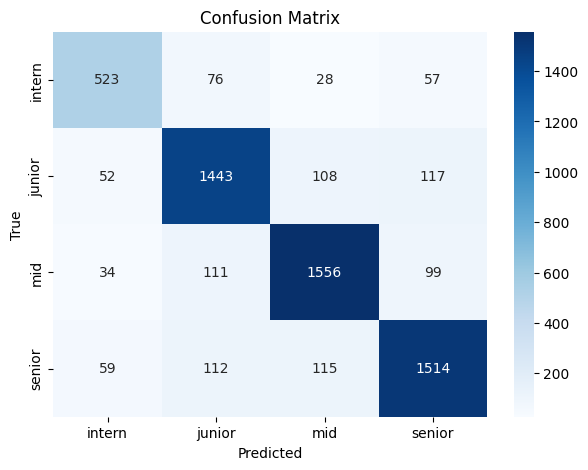

In [55]:
accuracy = evaluate_seniority(model, X_val, y_val)

83% -> pretty good for using only 32 d title and 32 d summary